<a href="https://colab.research.google.com/github/ZwwWayne/mmdetection/blob/update-colab/demo/MMDet_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MMDetection Tutorial

Welcome to MMDetection! This is the official colab tutorial for using MMDetection. In this tutorial, you will learn
- Perform inference with a MMDet detector.
- Train a new detector with a new dataset.

Let's start!


In [1]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Thu_Jun_11_22:26:38_PDT_2020
Cuda compilation tools, release 11.0, V11.0.194
Build cuda_11.0_bu.TC445_37.28540450_0
gcc (GCC) 4.8.5 20150623 (Red Hat 4.8.5-39)
Copyright (C) 2015 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



### Modify the config

In the next step, we need to modify the config for the training.
To accelerate the process, we finetune a detector using a pre-trained detector.

In [2]:
%cd mmdetection
import mmcv

/data/Detection_proj/mmdetection


In [3]:
from mmcv import Config
from pprint import pprint
cfg = Config.fromfile('./configs/retinanet/retinanet_r50_caffe_fpn_mstrain_2x_coco.py')
print(cfg.pretty_text)

model = dict(
    type='RetinaNet',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=False),
        norm_eval=True,
        style='caffe',
        init_cfg=dict(
            type='Pretrained',
            checkpoint='open-mmlab://detectron2/resnet50_caffe')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        start_level=1,
        add_extra_convs='on_input',
        num_outs=5),
    bbox_head=dict(
        type='RetinaHead',
        num_classes=80,
        in_channels=256,
        stacked_convs=4,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            octave_base_scale=4,
            scales_per_octave=3,
            ratios=[0.5, 1.0, 2.0],
            strides=[8, 16, 32, 64, 128]),
        bbox_coder=dict(
            type='DeltaXYWHBBo

Given a config that trains a Faster R-CNN on COCO dataset, we need to modify some values to use it for training Faster R-CNN on KITTI dataset.

In [4]:
import os
import os.path as osp
from mmdet.apis import set_random_seed
CLASS = ['china','us','uk','russia','japan','france','german','italy','australia','korea','other']
                
# Modify dataset type and path
cfg.data_root = '/data/flag/Images'
cfg.classes = CLASS

cfg.data.test.img_prefix = '/data/flag/Images'
cfg.data.test.ann_file = '/data/flag/flag_coco_test.json'
cfg.data.test.classes = CLASS

cfg.data.train.ann_file = '/data/flag/flag_coco_train.json'
cfg.data.train.img_prefix = '/data/flag/Images'
cfg.data.train.classes = CLASS

cfg.data.val.img_prefix = '/data/flag/Images'
cfg.data.val.ann_file = '/data/flag/flag_coco_val.json'
cfg.data.val.classes = CLASS

# modify num classes of the model in box head
cfg.model.bbox_head.num_classes = 11
#cfg.model.roi_head.mask_head.num_classes = 1
# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
#cfg.load_from = 'checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_\
#coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'
cfg.load_from = 'checkpoints/retinanet_r50_fpn_2x_coco_20200131-fdb43119.pth' #'checkpoints/retinanet_r50_fpn_1x_coco_20200130-c2398f9e.pth'
# Set up working dir to save files and logs.
cfg.work_dir = './flag_proj/RetinaNet'

if not os.path.exists(cfg.work_dir):
    os.makedirs(cfg.work_dir)
# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optimizer.lr = 0.00001 # 0.01 / 16
#cfg.lr_config.warmup = None
#log interval by step not epoch
cfg.log_config.interval = 50

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = ['bbox']
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 1
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 1

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

cfg.workflow = [('train',1),('val',1)]

#cfg.runner.max_epochs = 1

# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')
cfg.dump(osp.join(cfg.work_dir, 'flag_config.py'))

Config:
model = dict(
    type='RetinaNet',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=False),
        norm_eval=True,
        style='caffe',
        init_cfg=dict(
            type='Pretrained',
            checkpoint='open-mmlab://detectron2/resnet50_caffe')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        start_level=1,
        add_extra_convs='on_input',
        num_outs=5),
    bbox_head=dict(
        type='RetinaHead',
        num_classes=11,
        in_channels=256,
        stacked_convs=4,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            octave_base_scale=4,
            scales_per_octave=3,
            ratios=[0.5, 1.0, 2.0],
            strides=[8, 16, 32, 64, 128]),
        bbox_coder=dict(
            type='Delt

### Train a new detector

Finally, lets initialize the dataset and detector, then train a new detector!

In [5]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector
import os.path as osp
import copy

# Build dataset
datasets = [build_dataset(cfg.data.train)]
if len(cfg.workflow) == 2:
    val_dataset = copy.deepcopy(cfg.data.val)
    val_dataset.pipeline = cfg.data.train.pipeline
    datasets.append(build_dataset(val_dataset))
# Build the detector
model = build_detector(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


/data/Detection_proj/mmdetection/mmdet/core/anchor/builder.py:16: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  '``build_anchor_generator`` would be deprecated soon, please use '


In [5]:
datasets[0]


CocoDataset Train dataset with number of images 2527, and instance counts: 
+------------+-------+------------+-------+-----------+-------+---------------+-------+-----------+-------+
| category   | count | category   | count | category  | count | category      | count | category  | count |
+------------+-------+------------+-------+-----------+-------+---------------+-------+-----------+-------+
| 0 [china]  | 2335  | 1 [us]     | 310   | 2 [uk]    | 349   | 3 [russia]    | 153   | 4 [japan] | 582   |
| 5 [france] | 206   | 6 [german] | 180   | 7 [italy] | 161   | 8 [australia] | 66    | 9 [korea] | 947   |
+------------+-------+------------+-------+-----------+-------+---------------+-------+-----------+-------+

In [6]:
model

RetinaNet(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
         

In [7]:
model.CLASSES

['china',
 'us',
 'uk',
 'russia',
 'japan',
 'france',
 'german',
 'italy',
 'australia',
 'korea',
 'other']

In [ ]:
train_detector(model, datasets, cfg, distributed=False, validate=True)

2021-07-07 11:29:14,916 - mmdet - INFO - load checkpoint from checkpoints/retinanet_r50_fpn_2x_coco_20200131-fdb43119.pth
2021-07-07 11:29:14,917 - mmdet - INFO - Use load_from_local loader
2021-07-07 11:29:15,082 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for bbox_head.retina_cls.weight: copying a param with shape torch.Size([720, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([99, 256, 3, 3]).
size mismatch for bbox_head.retina_cls.bias: copying a param with shape torch.Size([720]) from checkpoint, the shape in current model is torch.Size([99]).
2021-07-07 11:29:15,092 - mmdet - INFO - Start running, host: root@VM-116-54-centos, work_dir: /data/Detection_proj/mmdetection/flag_proj/RetinaNet
2021-07-07 11:29:15,093 - mmdet - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(NORMAL      ) EvalHook     

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


/data/Detection_proj/mmdetection/mmdet/core/anchor/anchor_generator.py:323: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/data/Detection_proj/mmdetection/mmdet/core/anchor/anchor_generator.py:360: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '
2021-07-07 11:30:01,918 - mmdet - INFO - Epoch [1][50/1264]	lr: 9.890e-07, eta: 7:47:32, time: 0.926, data_time: 0.047, memory: 2932, loss_cls: 8713.0733, loss_bbox: 8.3411, loss: 8721.4143
2021-07-07 11:30:46,218 - mmdet - INFO - Epoch [1][100/1264]	lr: 1.988e-06, eta: 7:36:44, time: 0.886, data_time: 0.013, memory: 2932, loss_cls: 15.0031, loss_bbox: 1.2125, loss: 16.2156
2021-07-07 11:31:30,449 - mmdet - INFO - Epoch [1][150/1264]	lr: 2.987e-06, eta: 7:32:32, time: 0.886, data_time: 0.013, memory: 2932, loss_cls: 4.5279, l

### Understand the log
From the log, we can have a basic understanding the training process and know how well the detector is trained.

Firstly, the ResNet-50 backbone pre-trained on ImageNet is loaded, this is a common practice since training from scratch is more cost. The log shows that all the weights of the ResNet-50 backbone are loaded except the `conv1.bias`, which has been merged into `conv.weights`.

Second, since the dataset we are using is small, we loaded a Mask R-CNN model and finetune it for detection. Because the detector we actually using is Faster R-CNN, the weights in mask branch, e.g. `roi_head.mask_head`, are `unexpected key in source state_dict` and not loaded.
The original Mask R-CNN is trained on COCO dataset which contains 80 classes but KITTI Tiny dataset only have 3 classes. Therefore, the last FC layer of the pre-trained Mask R-CNN for classification has different weight shape and is not used.

Third, after training, the detector is evaluated by the default VOC-style evaluation. The results show that the detector achieves 54.1 mAP on the val dataset,
 not bad!

## Test the trained detector

After finetuning the detector, let's visualize the prediction results!

/content/mmdetection/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)
/content/mmdetection/mmdet/apis/inference.py:205: UserWarning: "block" will be deprecated in v2.9.0,Please use "wait_time"
  warnings.warn('"block" will be deprecated in v2.9.0,'
/content/mmdetection/mmdet/apis/inference.py:207: UserWarning: "fig_size" are deprecated and takes no effect.
  warnings.warn('"fig_size" are deprecated and takes no effect.')
/content/mmdetection/mmdet/core/visualization/image.py:75: UserWarning: "font_scale" will be deprecated in v2.9.0,Please use "font_size"
  warnings.warn('"font_scale" will be deprecated in v2.9.0,'


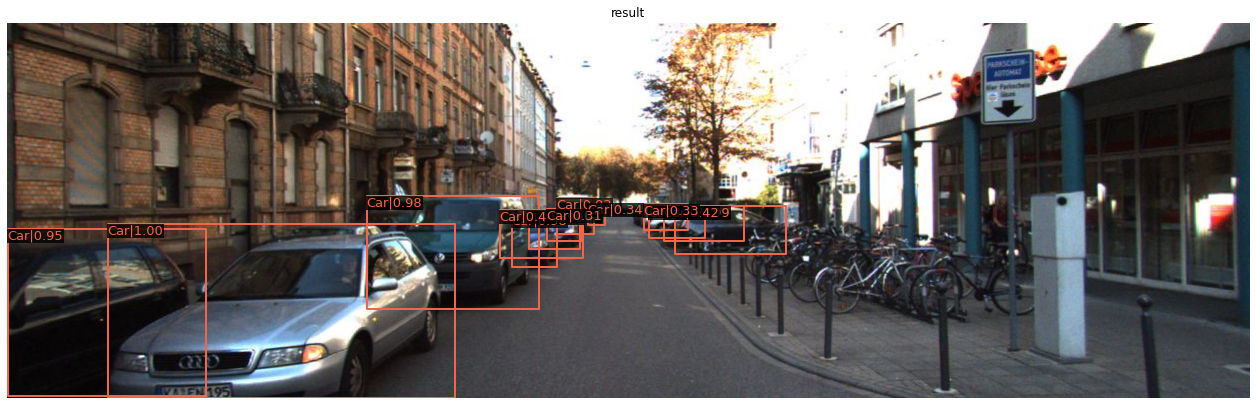

In [16]:
img = mmcv.imread('kitti_tiny/training/image_2/000068.jpeg')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)
